# Project 4
______

In [957]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import missingno as msno


### Covid surveillance data

In [958]:
#setting options to be able to see whole text in dataframe columns
pd.set_option("display.max_rows", None, "display.max_columns", None)
pd.set_option('max_colwidth',800)

In [959]:
# url='https://drive.google.com/file/d/1muBh32vAqHnyTnir-kW0bvnVTqd2k6ZC/view?usp=sharing'
# dnld_link='https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
# print(dnld_link)

In [960]:
# df_surv=pd.read_csv(dnld_link)

In [1085]:
df_surv=pd.read_csv('../data/covid_surveillance.csv')

In [1086]:
df_surv.head()

,case_month,res_state,state_fips_code,res_county,county_fips_code,age_group,sex,race,ethnicity,case_positive_specimen,process,exposure_yn,current_status,symptom_status,hosp_yn,icu_yn,death_yn,case_onset_interval,underlying_conditions_yn
0,2022-05,KY,21,JEFFERSON,21111.0,65+ years,Female,White,Non-Hispanic/Latino,0.0,Missing,Missing,Probable Case,Missing,No,Missing,No,NaN,NaN
1,2022-01,WI,55,RACINE,55101.0,50 to 64 years,Male,White,Non-Hispanic/Latino,NaN,Missing,Missing,Laboratory-confirmed case,Missing,Unknown,Missing,Unknown,NaN,NaN
2,2022-01,LA,22,CADDO,22017.0,18 to 49 years,Female,Unknown,Unknown,0.0,Missing,Missing,Laboratory-confirmed case,Unknown,Unknown,Unknown,Missing,NaN,NaN
3,2021-04,FL,12,LEE,12071.0,18 to 49 years,Female,NaN,NaN,-10.0,Missing,Missing,Laboratory-confirmed case,Symptomatic,No,Missing,No,0.0,NaN
4,2021-08,NC,37,NEW HANOVER,37129.0,0 - 17 years,Female,White,Hispanic/Latino,0.0,Missing,Unknown,Probable Case,Symptomatic,No,Unknown,No,0.0,NaN


In [963]:
df_surv.shape

(500000, 19)

In [964]:
df_surv.isnull().sum()

case_month                       0
res_state                        0
state_fips_code                  0
res_county                     871
county_fips_code               871
age_group                     3024
sex                           7959
race                         64748
ethnicity                    75698
case_positive_specimen      270451
process                          0
exposure_yn                      0
current_status                   0
symptom_status                   0
hosp_yn                          0
icu_yn                           0
death_yn                     18368
case_onset_interval         291941
underlying_conditions_yn    483518
dtype: int64

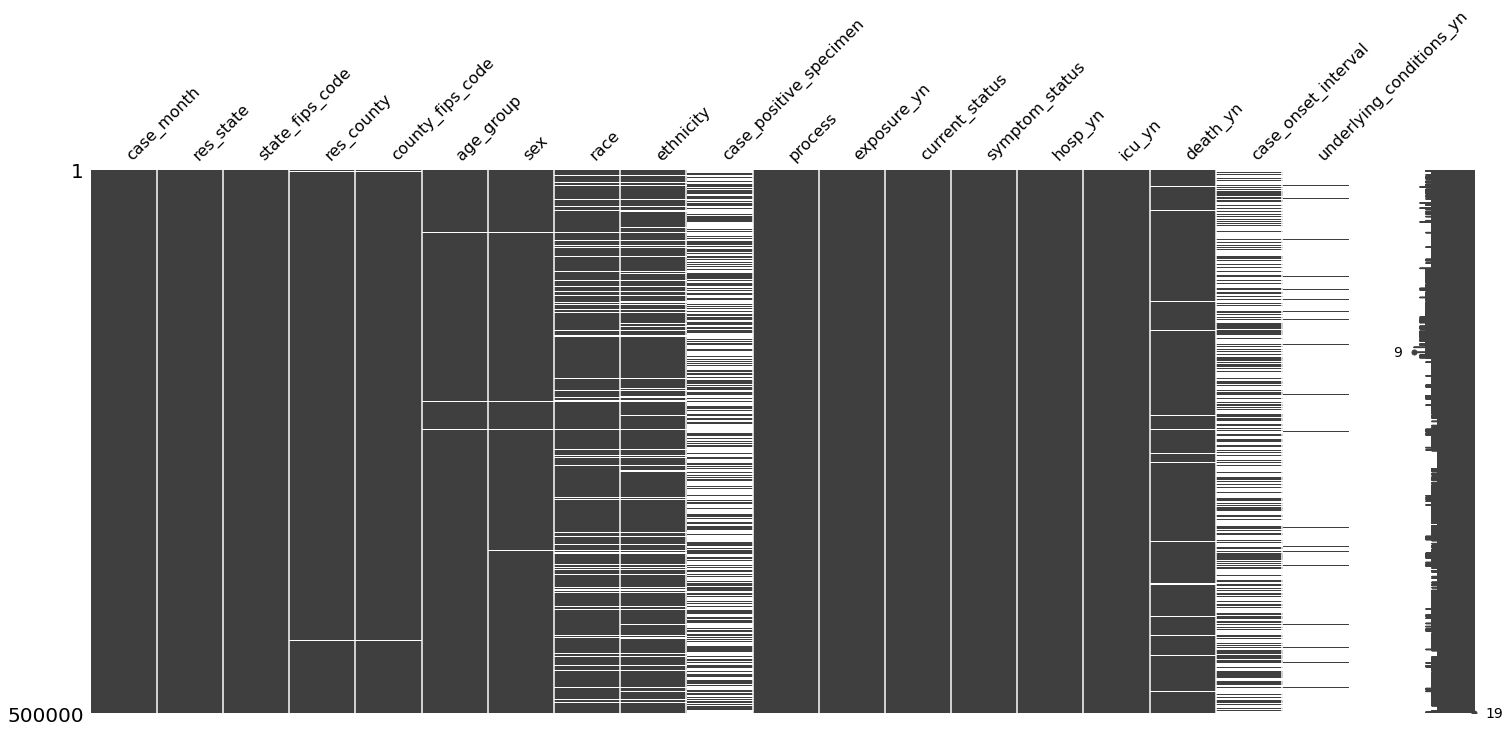

In [965]:
msno.matrix(df_surv);

The figure above shows null values across the data sets. Seems like 'case_positive_specimen', case_onset_interval' and 'underlying_conditions_yn' have lots of null values.

In [966]:
# Dropping state_fips_code, county_fips_code, and columns with a lot of null values
df_surv.drop(columns=['state_fips_code', 'county_fips_code', 'case_positive_specimen','case_onset_interval','underlying_conditions_yn'], inplace=True)

In [967]:
df_surv.isnull().sum();

In [968]:
#no. of states in the dataset
len(df_surv['res_state'].unique())

49

The file contains data from 49 states

In [969]:
df_surv.head()

,case_month,res_state,res_county,age_group,sex,race,ethnicity,process,exposure_yn,current_status,symptom_status,hosp_yn,icu_yn,death_yn
0,2022-05,KY,JEFFERSON,65+ years,Female,White,Non-Hispanic/Latino,Missing,Missing,Probable Case,Missing,No,Missing,No
1,2022-01,WI,RACINE,50 to 64 years,Male,White,Non-Hispanic/Latino,Missing,Missing,Laboratory-confirmed case,Missing,Unknown,Missing,Unknown
2,2022-01,LA,CADDO,18 to 49 years,Female,Unknown,Unknown,Missing,Missing,Laboratory-confirmed case,Unknown,Unknown,Unknown,Missing
3,2021-04,FL,LEE,18 to 49 years,Female,NaN,NaN,Missing,Missing,Laboratory-confirmed case,Symptomatic,No,Missing,No
4,2021-08,NC,NEW HANOVER,0 - 17 years,Female,White,Hispanic/Latino,Missing,Unknown,Probable Case,Symptomatic,No,Unknown,No


In [970]:
df_surv.dtypes

case_month        object
res_state         object
res_county        object
age_group         object
sex               object
race              object
ethnicity         object
process           object
exposure_yn       object
current_status    object
symptom_status    object
hosp_yn           object
icu_yn            object
death_yn          object
dtype: object

**Checking values for each column of interest**

In [971]:
df_surv['current_status'].value_counts()

Laboratory-confirmed case    413088
Probable Case                 86912
Name: current_status, dtype: int64

In [972]:
df_surv['age_group'].value_counts()

18 to 49 years    260410
50 to 64 years     89260
0 - 17 years       79883
65+ years          62161
Missing             5262
Name: age_group, dtype: int64

In [973]:
df_surv['ethnicity'].value_counts()

Non-Hispanic/Latino    269710
Unknown                 87237
Hispanic/Latino         34103
Missing                 33252
Name: ethnicity, dtype: int64

In [974]:
df_surv['race'].value_counts()

White                                     268251
Unknown                                    62907
Black                                      49195
Missing                                    36247
Asian                                       7746
Multiple/Other                              7063
American Indian/Alaska Native               3684
Native Hawaiian/Other Pacific Islander       159
Name: race, dtype: int64

In [975]:
df_surv['process'].value_counts()

Missing                            480591
Clinical evaluation                  9660
Laboratory reported                  4206
Routine surveillance                 1476
Unknown                              1234
Contact tracing of case patient      1008
Multiple                              960
Provider reported                     612
Other                                 251
Autopsy                                 2
Name: process, dtype: int64

In [976]:
df_surv['exposure_yn'].value_counts()

Missing    465931
Yes         22616
Unknown     11453
Name: exposure_yn, dtype: int64

In [977]:
df_surv['symptom_status'].value_counts()

Missing         238717
Symptomatic     195669
Unknown          60279
Asymptomatic      5335
Name: symptom_status, dtype: int64

In [978]:
df_surv['hosp_yn'].value_counts()

Missing    222775
No         163411
Unknown     98627
Yes         15187
Name: hosp_yn, dtype: int64

In [979]:
df_surv['icu_yn'].value_counts()

Missing    413879
Unknown     73333
No          11936
Yes           852
Name: icu_yn, dtype: int64

In [980]:
df_surv['death_yn'].value_counts()

Missing    221094
No         177586
Unknown     81179
Yes          1773
Name: death_yn, dtype: int64

In [981]:
#dropping some more columns that have more than 450,000 missing values
df_surv.drop(columns=['process','exposure_yn'], inplace=True)

In [982]:
df_surv_master=df_surv.copy()

In [983]:
df_surv.isnull().sum()

case_month            0
res_state             0
res_county          871
age_group          3024
sex                7959
race              64748
ethnicity         75698
current_status        0
symptom_status        0
hosp_yn               0
icu_yn                0
death_yn          18368
dtype: int64

In [984]:
# df_surv.to_csv('../data/clean_data/covid_surveillance_clean.csv', index=False)

In [985]:
#Deciding to work with State column, dropping county 

df_surv.drop(columns=['res_county'], inplace=True)

In [986]:
#Dropping all the nulls
df_surv.dropna(inplace=True)

In [987]:
df_surv.shape

(412936, 11)

In [988]:
df_surv.isnull().sum()

case_month        0
res_state         0
age_group         0
sex               0
race              0
ethnicity         0
current_status    0
symptom_status    0
hosp_yn           0
icu_yn            0
death_yn          0
dtype: int64

In [989]:
#converting case_month to DateTime
df_surv['case_month']=pd.to_datetime(df_surv['case_month'])

In [990]:
#setting case_month as index
df_surv.set_index('case_month', inplace=True)

In [991]:
# sorting index
df_surv.sort_index(inplace=True)

In [992]:

list_of_columns_to_survey= df_surv.columns

for col_name in list_of_columns_to_survey:
    print('------  VALUE COUNTS ------------------')
    print(f'Column name: {col_name}')
    print(df_surv[col_name].value_counts())
    print('----------------------------------------')

------  VALUE COUNTS ------------------
Column name: res_state
TX    26791
NC    22201
PA    22135
CA    21691
FL    20441
OH    20427
NY    18046
IL    16886
GA    15496
NJ    14973
MI    14185
IN    13972
TN    12669
SC    12567
WI    11388
LA    11194
WA     9779
MD     9671
VA     9266
MN     9158
AL     8167
MO     8129
CO     7840
AZ     7464
MA     6587
OR     5433
UT     4996
AR     4929
NM     4720
KS     3825
ID     3703
CT     3247
NH     3038
KY     3033
ME     3014
MT     2511
RI     2386
OK     2058
DE     1956
NE     1743
ND     1740
NV     1669
HI     1627
AK     1575
SD     1478
IA     1366
WY      745
VT      647
DC      374
Name: res_state, dtype: int64
----------------------------------------
------  VALUE COUNTS ------------------
Column name: age_group
18 to 49 years    226532
50 to 64 years     72701
0 - 17 years       60208
65+ years          48668
Missing             4827
Name: age_group, dtype: int64
----------------------------------------
------  VALUE COUNT

In [993]:
df_surv.head()

,res_state,age_group,sex,race,ethnicity,current_status,symptom_status,hosp_yn,icu_yn,death_yn
case_month,,,,,,,,,,
2020-03-01,PA,18 to 49 years,Female,White,Non-Hispanic/Latino,Laboratory-confirmed case,Symptomatic,Unknown,Unknown,Unknown
2020-03-01,LA,65+ years,Male,Black,Non-Hispanic/Latino,Laboratory-confirmed case,Unknown,Unknown,Unknown,Missing
2020-03-01,NJ,18 to 49 years,Female,Black,Non-Hispanic/Latino,Laboratory-confirmed case,Symptomatic,Missing,Missing,No
2020-03-01,PA,18 to 49 years,Female,White,Non-Hispanic/Latino,Laboratory-confirmed case,Symptomatic,No,No,No
2020-03-01,MI,18 to 49 years,Female,White,Non-Hispanic/Latino,Probable Case,Symptomatic,No,Missing,No


In [994]:
df_surv.tail()

,res_state,age_group,sex,race,ethnicity,current_status,symptom_status,hosp_yn,icu_yn,death_yn
case_month,,,,,,,,,,
2022-09-01,PA,65+ years,Female,White,Non-Hispanic/Latino,Laboratory-confirmed case,Symptomatic,Unknown,Unknown,Unknown
2022-09-01,OH,0 - 17 years,Male,White,Non-Hispanic/Latino,Laboratory-confirmed case,Symptomatic,Missing,Missing,No
2022-09-01,MI,0 - 17 years,Female,White,Non-Hispanic/Latino,Laboratory-confirmed case,Missing,Missing,Missing,Unknown
2022-09-01,NC,50 to 64 years,Male,White,Unknown,Probable Case,Unknown,Unknown,Unknown,No
2022-09-01,CO,65+ years,Female,Missing,Non-Hispanic/Latino,Laboratory-confirmed case,Missing,Missing,Missing,Missing


The surveillance data is from March 2020 to September 2022

In [995]:
#Dropping current_status column as it does not add much insight into EDA
df_surv.drop(columns=['current_status'],inplace=True)

In [996]:
df_surv.head()

,res_state,age_group,sex,race,ethnicity,symptom_status,hosp_yn,icu_yn,death_yn
case_month,,,,,,,,,
2020-03-01,PA,18 to 49 years,Female,White,Non-Hispanic/Latino,Symptomatic,Unknown,Unknown,Unknown
2020-03-01,LA,65+ years,Male,Black,Non-Hispanic/Latino,Unknown,Unknown,Unknown,Missing
2020-03-01,NJ,18 to 49 years,Female,Black,Non-Hispanic/Latino,Symptomatic,Missing,Missing,No
2020-03-01,PA,18 to 49 years,Female,White,Non-Hispanic/Latino,Symptomatic,No,No,No
2020-03-01,MI,18 to 49 years,Female,White,Non-Hispanic/Latino,Symptomatic,No,Missing,No


**compare with population percentage of age groups**

### Looking at the demographics for COVID cases over the period of March 2020 to Sept 2022

In [997]:
#Defining function to calculate counts and percentage count of various column categories
#Help from https://stackoverflow.com/questions/37947479/pandas-sum-two-rows-of-dataframe-without-rearranging-dataframe

def case_count(col_name):
    case_count=pd.DataFrame(df_surv[col_name].value_counts())
    case_count['percent']=df_surv[col_name].value_counts(normalize=True)
    try:
        case_count.loc['Unknown'] +=case_count.loc['Missing']
        case_count.drop(['Missing'], inplace=True)
    except:
        pass
    case_count.reset_index(inplace=True)
    case_count.columns=[col_name,'count','percent']
    try:
        case_count[col_name]=case_count[col_name].map(lambda x: 'Unknown/Missing' if x=='Unknown' else x)
    except:
        pass
    case_count.loc['Total']=[case_count[x].sum() if case_count[x].dtype not in ['object'] else 'Total' for x in case_count.columns]
    return case_count

In [998]:
#function to create percent count bar plots
def bar_plot(df):

    plt.figure(figsize=(4,6))
    plt.bar( x=df.iloc[:-1,0], height=df.iloc[:-1,2]*100, width=0.6, alpha=0.5)
    plt.xticks(rotation=60);
    # col_name=df.columns[0]
    plt.title(f'{df.columns[0]}', size=14)
    plt.ylabel('Percentage', size=14)
    plt.xticks(size=14)
    # plt.tight_layout()
    # plt.subplots_adjust(left=0.2, right=0.5, top=0.8, bottom=0.1)
    # plt.ylim(0,250000);


In [999]:
case_count_sex=case_count('sex')
case_count_sex

,sex,count,percent
0,Female,216977,0.525449
1,Male,191513,0.463784
2,Unknown/Missing,4446,0.010767
Total,Total,412936,1.000000


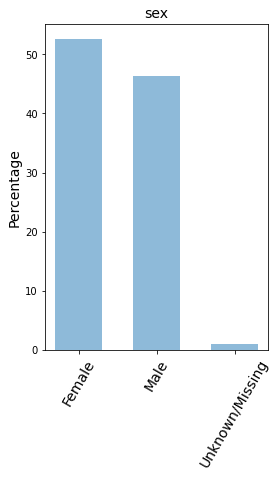

In [1000]:
bar_plot(case_count_sex)

In [1001]:
case_count_race=case_count('race')
case_count_race

,race,count,percent
0,White,258077,0.624981
1,Unknown/Missing,94896,0.229808
2,Black,45213,0.109492
3,Asian,6808,0.016487
4,Multiple/Other,4555,0.011031
5,American Indian/Alaska Native,3256,0.007885
6,Native Hawaiian/Other Pacific Islander,131,0.000317
Total,Total,412936,1.000000


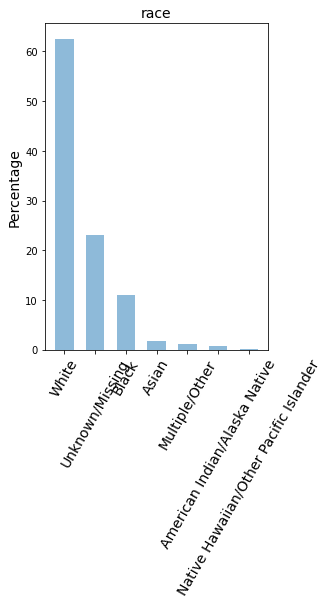

In [1002]:
bar_plot(case_count_race)

In [1003]:
case_count_ethnicity=case_count('ethnicity')
case_count_ethnicity

,ethnicity,count,percent
0,Non-Hispanic/Latino,262518,0.635735
1,Unknown/Missing,117968,0.285681
2,Hispanic/Latino,32450,0.078584
Total,Total,412936,1.000000


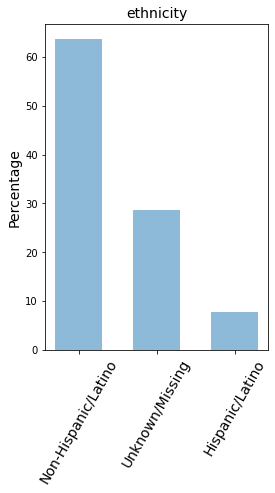

In [1004]:
bar_plot(case_count_ethnicity)

In [1005]:
case_count_age=case_count('age_group')
case_count_age

,age_group,count,percent
0,18 to 49 years,226532,0.548589
1,50 to 64 years,72701,0.176059
2,0 - 17 years,60208,0.145805
3,65+ years,48668,0.117858
4,Missing,4827,0.011689
Total,Total,412936,1.000000


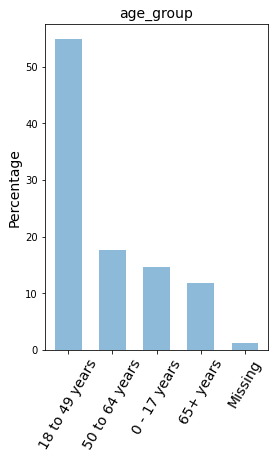

In [1006]:
bar_plot(case_count_age)

In [1007]:
df_surv['hosp_yn'].value_counts()

Missing    186852
No         133293
Unknown     82062
Yes         10729
Name: hosp_yn, dtype: int64

In [1008]:
case_count_state=case_count('res_state')
case_count_state

,res_state,count,percent
0,TX,26791,0.064879
1,NC,22201,0.053764
2,PA,22135,0.053604
3,CA,21691,0.052529
4,FL,20441,0.049502
5,OH,20427,0.049468
6,NY,18046,0.043702
7,IL,16886,0.040893
8,GA,15496,0.037526
9,NJ,14973,0.036260


In [1009]:
#Creating a Dataframe with all the state names and abbreviations
df_states=pd.read_csv('../data/US_state_two_letter_abbreviations.csv')

In [1010]:
df_states.rename(columns={'State_ID': 'res_state'}, inplace=True)
df_states['res_state_name']=df_states['State']
df_states.drop(columns='State', inplace=True)

In [1011]:
df_states=pd.concat([df_states, pd.DataFrame({'res_state': ['DC'], 'res_state_name':['Washington DC']})])

In [1012]:
df_states.reset_index(inplace=True)
df_states.drop(columns=['index'], inplace=True)

In [1013]:
df_states.head()

,res_state,res_state_name
0,AL,Alabama
1,AK,Alaska
2,AZ,Arizona
3,AR,Arkansas
4,CA,California


In [1014]:
case_count_state=pd.merge(case_count_state, df_states, on='res_state', how='outer')

In [1015]:
case_count_state

,res_state,count,percent,res_state_name
0,TX,26791.0,0.064879,Texas
1,NC,22201.0,0.053764,North Carolina
2,PA,22135.0,0.053604,Pennsylvania
3,CA,21691.0,0.052529,California
4,FL,20441.0,0.049502,Florida
5,OH,20427.0,0.049468,Ohio
6,NY,18046.0,0.043702,New York
7,IL,16886.0,0.040893,Illinois
8,GA,15496.0,0.037526,Georgia
9,NJ,14973.0,0.036260,New Jersey


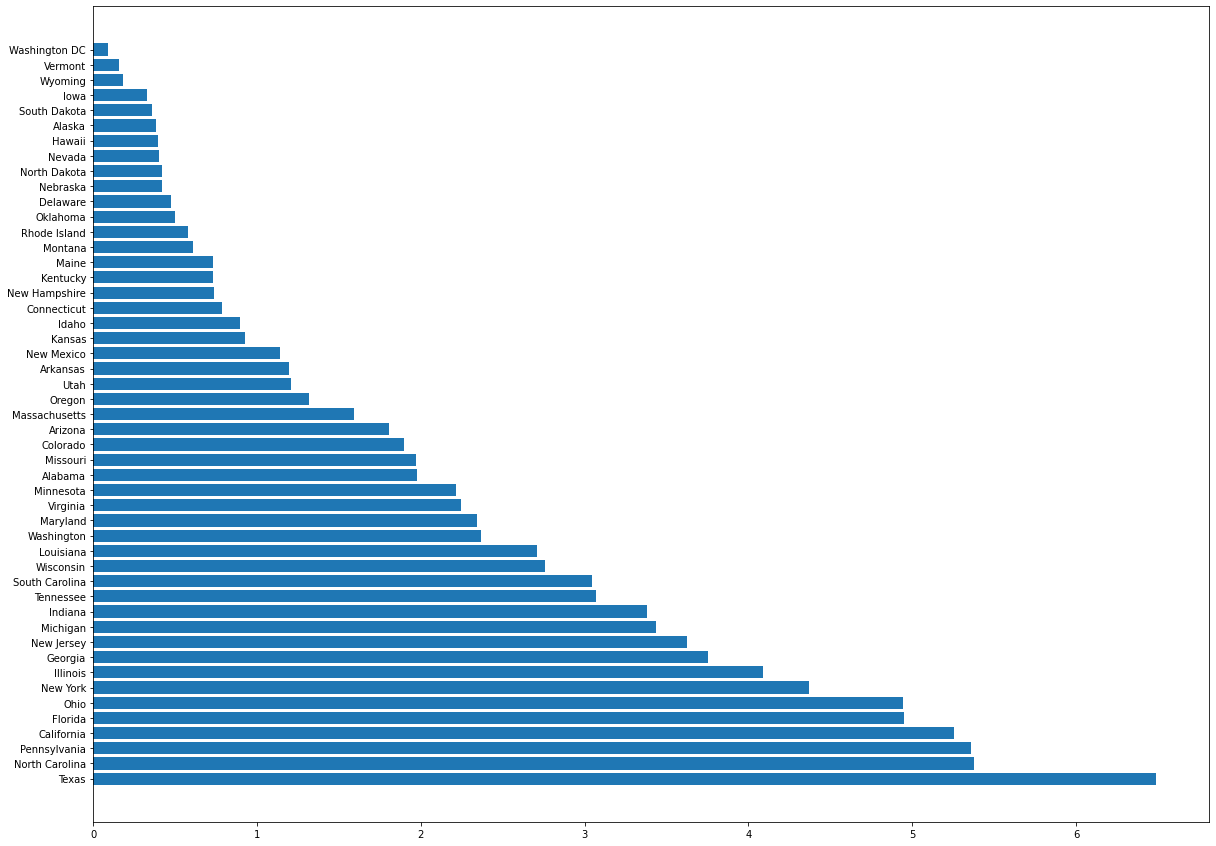

In [1016]:
plt.figure(figsize=(20,15))
plt.barh( y=case_count_state.iloc[:-3,3], width=case_count_state.iloc[:-3,2]*100);

**Looking at Hospitalization, icu and death data**

In [1017]:
df_surv.head()

,res_state,age_group,sex,race,ethnicity,symptom_status,hosp_yn,icu_yn,death_yn
case_month,,,,,,,,,
2020-03-01,PA,18 to 49 years,Female,White,Non-Hispanic/Latino,Symptomatic,Unknown,Unknown,Unknown
2020-03-01,LA,65+ years,Male,Black,Non-Hispanic/Latino,Unknown,Unknown,Unknown,Missing
2020-03-01,NJ,18 to 49 years,Female,Black,Non-Hispanic/Latino,Symptomatic,Missing,Missing,No
2020-03-01,PA,18 to 49 years,Female,White,Non-Hispanic/Latino,Symptomatic,No,No,No
2020-03-01,MI,18 to 49 years,Female,White,Non-Hispanic/Latino,Symptomatic,No,Missing,No


In [1018]:
case_count_hosp=case_count('hosp_yn')
case_count_hosp

,hosp_yn,count,percent
0,No,133293,0.322793
1,Unknown/Missing,268914,0.651224
2,Yes,10729,0.025982
Total,Total,412936,1.000000


In [1019]:
case_count_icu=case_count('icu_yn')
case_count_icu

,icu_yn,count,percent
0,Unknown/Missing,402681,0.975166
1,No,9774,0.023670
2,Yes,481,0.001165
Total,Total,412936,1.000000


In [1020]:
case_count_death=case_count('death_yn')
case_count_death

,death_yn,count,percent
0,No,151470,0.366812
1,Unknown/Missing,259797,0.629146
2,Yes,1669,0.004042
Total,Total,412936,1.000000


In [1021]:
case_count_symptom=case_count('symptom_status')
case_count_symptom

,symptom_status,count,percent
0,Symptomatic,160046,0.387581
1,Unknown/Missing,248748,0.602389
2,Asymptomatic,4142,0.010031
Total,Total,412936,1.000000


There are large no. of missing/unknown entries for icu data

In [1022]:
#Deciding to drop the 'icu_yn' column because of large no of missing values
df_surv.drop(columns=['icu_yn'],inplace=True)

In [1040]:
df_surv.shape

(412936, 8)

The surveillance data is from January 2020 to September 2022

### Hospitalization EDA

Dropping the missing and unknown for hosp_yn

In [1023]:
#Dropping the rows containing missing or unknown values for hospitalization_yn column
df_surv_hosp=df_surv[(df_surv['hosp_yn']=='Yes') | (df_surv['hosp_yn']=='No')].copy()

In [1041]:
df_surv_hosp.shape

(144022, 8)

In [1037]:
#binarizing hosp_yn
df_surv_hosp['hosp_yn']=df_surv_hosp['hosp_yn'].map(lambda x: 1 if x=='Yes' else 0)

In [1038]:
df_surv_hosp.head()

,res_state,age_group,sex,race,ethnicity,symptom_status,hosp_yn,death_yn
case_month,,,,,,,,
2020-03-01,PA,18 to 49 years,Female,White,Non-Hispanic/Latino,Symptomatic,0,No
2020-03-01,MI,18 to 49 years,Female,White,Non-Hispanic/Latino,Symptomatic,0,No
2020-03-01,NJ,18 to 49 years,Male,Black,Non-Hispanic/Latino,Symptomatic,1,No
2020-03-01,PA,65+ years,Female,White,Non-Hispanic/Latino,Symptomatic,0,No
2020-03-01,NJ,18 to 49 years,Male,Black,Non-Hispanic/Latino,Symptomatic,1,No


In [1043]:
# df_surv_hospy=df_surv_hosp[df_surv_hosp['hosp_yn']==1].copy()
# df_surv_hospy.shape

(10729, 8)

In [1076]:
# df_surv_hospy.head()

In [1077]:
# df_NJ.head()

In [1066]:
df_surv_states=df_surv_hosp['res_state'].unique()

In [1071]:
df_surv_states

array(['PA', 'MI', 'NJ', 'MO', 'FL', 'LA', 'MA', 'MD', 'CO', 'TX', 'IA',
       'IL', 'WA', 'OH', 'WI', 'MN', 'CT', 'SC', 'NY', 'VA', 'AL', 'NC',
       'NM', 'NV', 'CA', 'OK', 'AZ', 'NH', 'OR', 'TN', 'AR', 'KY', 'IN',
       'GA', 'ID', 'KS', 'UT', 'ND', 'MT', 'WY', 'ME', 'DC', 'VT', 'AK',
       'NE', 'HI'], dtype=object)

In [1097]:
def plot_state_hosp(states):
    plt.figure(figsize=(8,6))
    df_state_hosp=[]

    for state in states:
        df_state=df_surv_hosp[df_surv_hosp['res_state']==state].copy()
        df_state.reset_index(inplace=True)
        state_hosp=df_state.groupby(by='case_month')['hosp_yn'].aggregate('sum')
        state_total=df_state.groupby(by='case_month')['hosp_yn'].aggregate('count')
        state_percentage=(state_hosp/state_total)*100
         # state_percentage;
        plt.plot(state_percentage, label=state)
    plt.title('Hospitalization Rates by State', size=14)
    plt.ylabel('Hospitalization (%)', size=14)
    plt.xlabel('Time', size=14)
    plt.xticks(rotation=90);
    plt.legend();

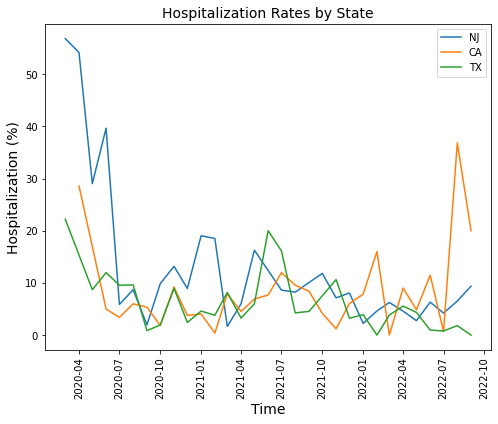

In [1101]:
#plotting hospitalization rates for three states
plot_state_hosp(['NJ','CA','TX'])

States with Highest recent hospitalization rate:- 

Cleaning the data of the missing and unknown values for modeling:

In [1031]:
#Dropping the rows containing missing or unknown values for death_yn column
# df_surv_hosp_clean=df_surv_hosp[(df_surv_hosp['death_yn']=='Yes') | (df_surv_hosp['death_yn']=='No')].copy()


#Dropping the rows containing missing or unknown values for sex
# df_surv_hosp_clean=df_surv_hosp[(df_surv_hosp['sex']!='Missing') & (df_surv_hosp['sex']!='Unknown')].copy()

#Dropping the rows containing missing or unknown values for race
# df_surv_hosp_clean=df_surv_hosp[(df_surv_hosp['race']!='Missing') & (df_surv_hosp['race']!='Unknown')].copy()

#Dropping the rows containing missing or unknown values for ethnicity
# df_surv_hosp=df_surv_hosp[(df_surv_hosp['ethnicity']!='Missing') & (df_surv_hosp['ethnicity']!='Unknown')].copy()

#Dropping the rows containing missing or unknown values for age_group
# df_surv_hosp=df_surv_hosp[(df_surv_hosp['age_group']!='Missing') & (df_surv_hosp['age_group']!='Unknown')].copy()


def clean_missing_unknown(df, clean_col_list):
    for col in clean_col_list:
        #Dropping the rows containing missing or unknown values for col
        df=df[(df[col]!='Missing') & (df[col]!='Unknown')].copy()
    return df


In [1029]:
clean_col_list=['sex','race','ethnicity','age_group']

In [1032]:
df_surv_hosp_clean=clean_missing_unknown(df_surv_hosp, clean_col_list)

In [1099]:
df_surv_hosp_clean.shape

(114644, 8)

In [1035]:

list_of_columns_to_survey= df_surv_hosp_clean.columns

for col_name in list_of_columns_to_survey:
    print(' VALUE COUNTS ')
    print(f'Column name: {col_name}')
    print(df_surv_hosp_clean[col_name].value_counts())
    print('----------------------------------------')

 VALUE COUNTS 
Column name: res_state
NJ    11521
IN     8978
FL     7590
NC     6341
WI     5934
OH     5438
IL     5125
UT     4938
SC     4877
MI     4624
CA     4073
VA     3957
TX     3493
AZ     2952
TN     2910
MD     2490
PA     2478
NY     2442
NM     2244
KS     1974
ME     1964
LA     1936
AR     1887
CO     1879
WA     1666
ID     1536
MT     1496
OR     1371
NV     1106
AL     1044
KY      964
OK      755
MN      541
WY      513
VT      500
MA      494
AK      138
DC      119
CT      100
IA       96
MO       75
GA       71
NH       13
HI        1
Name: res_state, dtype: int64
----------------------------------------
 VALUE COUNTS 
Column name: age_group
18 to 49 years    58230
50 to 64 years    22479
0 - 17 years      17180
65+ years         16755
Name: age_group, dtype: int64
----------------------------------------
 VALUE COUNTS 
Column name: sex
Female    59874
Male      54770
Name: sex, dtype: int64
----------------------------------------
 VALUE COUNTS 
Column name: r

In [953]:
# df_surv_hosp.shape

(80538, 8)

In [954]:

#Dropping the rows containing missing or unknown values for symptom_status
# df_surv_hosp2=df_surv_hosp[(df_surv_hosp['symptom_status']=='Symptomatic') | (df_surv_hosp['symptom_status']=='Asymptomatic')].copy()




In [882]:
# df_surv_hosp2.shape

(57234, 9)

In [883]:
df_surv_hosp.head()

,res_state,age_group,sex,race,ethnicity,symptom_status,hosp_yn,icu_yn,death_yn
case_month,,,,,,,,,
2020-03-01,PA,18 to 49 years,Female,White,Non-Hispanic/Latino,Symptomatic,No,No,No
2020-03-01,MI,18 to 49 years,Female,White,Non-Hispanic/Latino,Symptomatic,No,Missing,No
2020-03-01,NJ,18 to 49 years,Male,Black,Non-Hispanic/Latino,Symptomatic,Yes,Missing,No
2020-03-01,PA,65+ years,Female,White,Non-Hispanic/Latino,Symptomatic,No,No,No
2020-03-01,NJ,18 to 49 years,Male,Black,Non-Hispanic/Latino,Symptomatic,Yes,Missing,No


In [1100]:
df_surv_hosp_clean.to_csv('../data/clean_data/covid_surveillance_hospitalization.csv')

In [956]:
# df_surv_hosp2.to_csv('../data/clean_data/covid_surveillance_hospitalization2.csv')

In [307]:
df_pop=pd.read_csv('../data/US_population_NST-EST2021-alldata.csv')

In [308]:
df_pop.head()

,SUMLEV,REGION,DIVISION,STATE,NAME,ESTIMATESBASE2020,POPESTIMATE2020,POPESTIMATE2021,NPOPCHG_2020,NPOPCHG_2021,BIRTHS2020,BIRTHS2021,DEATHS2020,DEATHS2021,NATURALINC2020,NATURALINC2021,INTERNATIONALMIG2020,INTERNATIONALMIG2021,DOMESTICMIG2020,DOMESTICMIG2021,NETMIG2020,NETMIG2021,RESIDUAL2020,RESIDUAL2021,RBIRTH2021,RDEATH2021,RNATURALINC2021,RINTERNATIONALMIG2021,RDOMESTICMIG2021,RNETMIG2021
0,10,0,0,0,United States,331449281,331501080,331893745,51799,392665,893000,3581986,853448,3433943,39552,148043,12247,244622,0,0,12247,244622,0,0,10.798957,10.352637,0.446319,0.737485,0.000000,0.737485
1,20,1,0,0,Northeast Region,57609148,57525633,57159838,-83515,-365795,145067,570592,148129,601644,-3062,-31052,3314,56046,-82743,-389638,-79429,-333592,-1024,-1151,9.950554,10.492070,-0.541516,0.977386,-6.794897,-5.817511
2,20,2,0,0,Midwest Region,68985454,68935174,68841444,-50280,-93730,190941,748166,193237,761784,-2296,-13618,1678,37835,-48944,-123103,-47266,-85268,-718,5156,10.860566,11.058248,-0.197682,0.549222,-1.786994,-1.237772
3,20,3,0,0,South Region,126266107,126409007,127225329,142900,816322,345546,1416400,337628,1366769,7918,49631,6553,112394,127901,657682,134454,770076,528,-3385,11.168835,10.777476,0.391359,0.886268,5.186064,6.072332
4,20,4,0,0,West Region,78588572,78631266,78667134,42694,35868,211446,846828,174454,703746,36992,143082,702,38347,3786,-144941,4488,-106594,1214,-620,10.767153,8.947910,1.819243,0.487570,-1.842880,-1.355309


In [309]:
df_pop['NAME'].value_counts()

United States           1
Mississippi             1
Montana                 1
Nebraska                1
Nevada                  1
New Hampshire           1
New Jersey              1
New Mexico              1
New York                1
North Carolina          1
North Dakota            1
Ohio                    1
Oklahoma                1
Oregon                  1
Pennsylvania            1
Rhode Island            1
South Carolina          1
South Dakota            1
Tennessee               1
Texas                   1
Utah                    1
Vermont                 1
Virginia                1
Washington              1
West Virginia           1
Wisconsin               1
Wyoming                 1
Missouri                1
Minnesota               1
Northeast Region        1
Michigan                1
Midwest Region          1
South Region            1
West Region             1
Alabama                 1
Alaska                  1
Arizona                 1
Arkansas                1
California  

In [225]:
case_count_state.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, 0 to Total
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   res_state  50 non-null     object 
 1   count      50 non-null     int64  
 2   percent    50 non-null     float64
dtypes: float64(1), int64(1), object(1)
memory usage: 1.6+ KB


In [201]:
df_surv1.head()

,res_state,age_group,sex,race,ethnicity,symptom_status,hosp_yn,icu_yn,death_yn
case_month,,,,,,,,,
2020-03-01,PA,18 to 49 years,Female,White,Non-Hispanic/Latino,Symptomatic,Unknown,Unknown,Unknown
2020-03-01,LA,65+ years,Male,Black,Non-Hispanic/Latino,Unknown,Unknown,Unknown,Missing
2020-03-01,NJ,18 to 49 years,Female,Black,Non-Hispanic/Latino,Symptomatic,Missing,Missing,No
2020-03-01,PA,18 to 49 years,Female,White,Non-Hispanic/Latino,Symptomatic,No,No,No
2020-03-01,MI,18 to 49 years,Female,White,Non-Hispanic/Latino,Symptomatic,No,Missing,No


In [202]:
df_surv1.tail()

,res_state,age_group,sex,race,ethnicity,symptom_status,hosp_yn,icu_yn,death_yn
case_month,,,,,,,,,
2022-09-01,PA,65+ years,Female,White,Non-Hispanic/Latino,Symptomatic,Unknown,Unknown,Unknown
2022-09-01,OH,0 - 17 years,Male,White,Non-Hispanic/Latino,Symptomatic,Missing,Missing,No
2022-09-01,MI,0 - 17 years,Female,White,Non-Hispanic/Latino,Missing,Missing,Missing,Unknown
2022-09-01,NC,50 to 64 years,Male,White,Unknown,Unknown,Unknown,Unknown,No
2022-09-01,CO,65+ years,Female,Missing,Non-Hispanic/Latino,Missing,Missing,Missing,Missing


In [268]:
#Help from https://stackoverflow.com/questions/28679930/how-to-drop-rows-from-pandas-data-frame-that-contains-a-particular-string-in-a-p#:~:text=If%20your%20string%20constraint%20is%20not%20just%20one,drop%20all%20rows%20containing%20elements%20of%20your%20list

df_surv1=df_surv[~df_surv.sex.str.contains('|'.join(['Missing','Unknown']))]
df_surv1=df_surv[~df_surv.age_group.str.contains('|'.join(['Missing','Unknown']))]
df_surv1=df_surv[~df_surv.race.str.contains('|'.join(['Missing','Unknown']))]
df_surv1=df_surv[~df_surv.ethnicity.str.contains('|'.join(['Missing','Unknown']))]

In [269]:
df_surv1.shape

(294968, 11)

In [265]:
df_surv1.age_group.value_counts()

18 to 49 years    226532
50 to 64 years     72701
0 - 17 years       60208
65+ years          48668
Name: age_group, dtype: int64

In [105]:
df_surv1.head()

NameError: name 'df_surv1' is not defined

## COVID  cases and deaths by state over time

In [171]:
df_cases=pd.read_csv('../data/United_States_COVID-19_Cases_and_Deaths_by_State_over_Time.csv')

In [172]:
df_cases.head()

,submission_date,state,tot_cases,conf_cases,prob_cases,new_case,pnew_case,tot_death,conf_death,prob_death,new_death,pnew_death,created_at,consent_cases,consent_deaths
0,01/25/2020,OR,0,NaN,NaN,0,NaN,0,NaN,NaN,0,NaN,03/26/2020 04:22:39 PM,Agree,Agree
1,09/17/2021,MD,"516,784",NaN,NaN,"1,525",0,"10,282","10,056",226,11,0,09/19/2021 12:00:00 AM,NaN,Agree
2,10/12/2021,VT,"33,388",NaN,NaN,112,5,333,NaN,NaN,4,0,10/14/2021 12:00:00 AM,Not agree,Not agree
3,02/01/2021,DC,"37,008",NaN,NaN,136,0,916,NaN,NaN,3,0,02/02/2021 02:51:51 PM,NaN,NaN
4,12/19/2021,NC,"1,586,243","1,339,055","247,188","3,410",466,"19,480","17,148","2,332",19,3,12/19/2021 12:00:00 AM,Agree,Agree


In [173]:
#converting case_month to DateTime
# df_cases['submission_date']=pd.to_datetime(df_cases['submission_date'])

#setting case_month as index
# df_cases.set_index('submission_date', inplace=True)

#sorting index
# df_cases.sort_index(inplace=True)

In [174]:
df_cases.head()

,submission_date,state,tot_cases,conf_cases,prob_cases,new_case,pnew_case,tot_death,conf_death,prob_death,new_death,pnew_death,created_at,consent_cases,consent_deaths
0,01/25/2020,OR,0,NaN,NaN,0,NaN,0,NaN,NaN,0,NaN,03/26/2020 04:22:39 PM,Agree,Agree
1,09/17/2021,MD,"516,784",NaN,NaN,"1,525",0,"10,282","10,056",226,11,0,09/19/2021 12:00:00 AM,NaN,Agree
2,10/12/2021,VT,"33,388",NaN,NaN,112,5,333,NaN,NaN,4,0,10/14/2021 12:00:00 AM,Not agree,Not agree
3,02/01/2021,DC,"37,008",NaN,NaN,136,0,916,NaN,NaN,3,0,02/02/2021 02:51:51 PM,NaN,NaN
4,12/19/2021,NC,"1,586,243","1,339,055","247,188","3,410",466,"19,480","17,148","2,332",19,3,12/19/2021 12:00:00 AM,Agree,Agree


In [176]:
df_cases.tail();

In [177]:
df_cases.shape

(59640, 15)

In [178]:
# This code block will print the value counts for each column in the dataframe

list_of_columns_to_survey= df_cases.columns

for col_name in list_of_columns_to_survey:
    print('------  VALUE COUNTS ------------------')
    print(f'Column name: {col_name}')
    print(df_cases[col_name].value_counts())
    print('----------------------------------------')


------  VALUE COUNTS ------------------
Column name: submission_date
01/25/2020    60
08/20/2021    60
11/22/2020    60
12/23/2021    60
06/26/2022    60
              ..
08/08/2022    60
05/26/2021    60
07/03/2022    60
06/08/2021    60
12/02/2021    60
Name: submission_date, Length: 994, dtype: int64
----------------------------------------
------  VALUE COUNTS ------------------
Column name: state
OR     994
MD     994
AK     994
IN     994
NY     994
PW     994
IA     994
TN     994
HI     994
MA     994
GU     994
MS     994
GA     994
AL     994
RMI    994
OK     994
CO     994
NYC    994
MP     994
OH     994
AS     994
PR     994
SD     994
PA     994
TX     994
ND     994
NM     994
WV     994
WA     994
AR     994
UT     994
KS     994
FSM    994
VT     994
DC     994
NC     994
MI     994
CT     994
SC     994
CA     994
ID     994
IL     994
WY     994
WI     994
NH     994
NV     994
ME     994
MO     994
AZ     994
RI     994
LA     994
VA     994
MN     994
KY     994
N

In [179]:
df_cases.head()

,submission_date,state,tot_cases,conf_cases,prob_cases,new_case,pnew_case,tot_death,conf_death,prob_death,new_death,pnew_death,created_at,consent_cases,consent_deaths
0,01/25/2020,OR,0,NaN,NaN,0,NaN,0,NaN,NaN,0,NaN,03/26/2020 04:22:39 PM,Agree,Agree
1,09/17/2021,MD,"516,784",NaN,NaN,"1,525",0,"10,282","10,056",226,11,0,09/19/2021 12:00:00 AM,NaN,Agree
2,10/12/2021,VT,"33,388",NaN,NaN,112,5,333,NaN,NaN,4,0,10/14/2021 12:00:00 AM,Not agree,Not agree
3,02/01/2021,DC,"37,008",NaN,NaN,136,0,916,NaN,NaN,3,0,02/02/2021 02:51:51 PM,NaN,NaN
4,12/19/2021,NC,"1,586,243","1,339,055","247,188","3,410",466,"19,480","17,148","2,332",19,3,12/19/2021 12:00:00 AM,Agree,Agree


In [180]:
df_cases_master=df_cases.copy()
df_cases=df_cases[['state','tot_cases','new_case','tot_death','new_death']]

In [181]:
df_cases.isnull().sum()

state        0
tot_cases    0
new_case     0
tot_death    0
new_death    0
dtype: int64

In [182]:
df_cases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59640 entries, 0 to 59639
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   state      59640 non-null  object
 1   tot_cases  59640 non-null  object
 2   new_case   59640 non-null  object
 3   tot_death  59640 non-null  object
 4   new_death  59640 non-null  object
dtypes: object(5)
memory usage: 2.3+ MB


In [197]:
df_cases.to_csv('../data/clean_data/United_States_COVID-19_Cases_and_Deaths_by_State_over_Time_clean.csv', index=False)

### Vaccination trends

In [1088]:
df_vacc=pd.read_csv('../data/covid_vaccination_trends.csv', low_memory=False)

In [1089]:
df_vacc.shape

(74160, 25)

In [186]:
df_vacc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74160 entries, 0 to 74159
Data columns (total 25 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   Date                                         74160 non-null  object 
 1   date_type                                    74160 non-null  object 
 2   MMWR_week                                    74160 non-null  int64  
 3   Location                                     74160 non-null  object 
 4   Administered_Daily                           74160 non-null  object 
 5   Administered_Cumulative                      74160 non-null  object 
 6   Administered_7_Day_Rolling_Average           73140 non-null  object 
 7   Admin_Dose_1_Daily                           74160 non-null  object 
 8   Admin_Dose_1_Cumulative                      74160 non-null  object 
 9   Admin_Dose_1_Day_Rolling_Average             73140 non-null  object 
 10

In [1090]:
df_vacc.head()

,Date,date_type,MMWR_week,Location,Administered_Daily,Administered_Cumulative,Administered_7_Day_Rolling_Average,Admin_Dose_1_Daily,Admin_Dose_1_Cumulative,Admin_Dose_1_Day_Rolling_Average,Administered_Dose1_Pop_Pct,Administered_daily_change_report,Administered_daily_change_report_7dayroll,Series_Complete_Daily,Series_Complete_Cumulative,Series_Complete_Day_Rolling_Average,Series_Complete_Pop_Pct,Booster_Daily,Booster_Cumulative,Booster_7_Day_Rolling_Average,Additional_Doses_Vax_Pct,Second_Booster_50Plus_Daily,Second_Booster_50Plus_Cumulative,Second_Booster_50Plus_7_Day_Rolling_Average,Second_Booster_50Plus_Vax_Pct
0,10/12/2022,Report,41,DE,"17,883","2,005,782",NaN,"1,841","839,722",NaN,86.2,NaN,NaN,"1,571","698,543",NaN,71.7,"2,245","344,388",NaN,49.3,"4,311","96,891",NaN,42.0
1,10/12/2022,Report,41,CT,"5,733","8,273,306",NaN,"5,198","3,534,406",NaN,95.0,NaN,NaN,"1,658","2,904,048",NaN,81.5,"1,052","1,567,645",NaN,54.0,492,"374,525",NaN,40.4
2,10/12/2022,Report,41,CA,"3,409","81,763,386",NaN,"170,547","33,585,368",NaN,85.0,NaN,NaN,"22,577","29,259,889",NaN,74.1,"-130,515","16,291,249",NaN,55.7,"-40,176","3,578,567",NaN,42.9
3,10/12/2022,Report,41,NE,"21,694","3,489,100",NaN,"1,355","1,396,070",NaN,72.2,NaN,NaN,"1,182","1,260,587",NaN,65.2,"1,835","677,307",NaN,53.7,"4,749","161,952",NaN,40.2
4,10/12/2022,Report,41,PW,152,"49,838",NaN,9,"20,625",NaN,95.0,NaN,NaN,14,"18,383",NaN,85.4,32,"12,133",NaN,66.0,19,"1,194",NaN,24.7


In [1093]:
df_vacc.shape

(74160, 25)

In [188]:
df_vacc.isnull().sum()

Date                                              0
date_type                                         0
MMWR_week                                         0
Location                                          0
Administered_Daily                                0
Administered_Cumulative                           0
Administered_7_Day_Rolling_Average             1020
Admin_Dose_1_Daily                                0
Admin_Dose_1_Cumulative                           0
Admin_Dose_1_Day_Rolling_Average               1020
Administered_Dose1_Pop_Pct                        0
Administered_daily_change_report               6660
Administered_daily_change_report_7dayroll      7740
Series_Complete_Daily                             0
Series_Complete_Cumulative                        0
Series_Complete_Day_Rolling_Average            1020
Series_Complete_Pop_Pct                           0
Booster_Daily                                     0
Booster_Cumulative                                0
Booster_7_Da

In [189]:
df_vacc.dropna(inplace=True)

In [190]:
df_vacc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66420 entries, 7740 to 74159
Data columns (total 25 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   Date                                         66420 non-null  object 
 1   date_type                                    66420 non-null  object 
 2   MMWR_week                                    66420 non-null  int64  
 3   Location                                     66420 non-null  object 
 4   Administered_Daily                           66420 non-null  object 
 5   Administered_Cumulative                      66420 non-null  object 
 6   Administered_7_Day_Rolling_Average           66420 non-null  object 
 7   Admin_Dose_1_Daily                           66420 non-null  object 
 8   Admin_Dose_1_Cumulative                      66420 non-null  object 
 9   Admin_Dose_1_Day_Rolling_Average             66420 non-null  object 


In [191]:
df_vacc.head()

,Date,date_type,MMWR_week,Location,Administered_Daily,Administered_Cumulative,Administered_7_Day_Rolling_Average,Admin_Dose_1_Daily,Admin_Dose_1_Cumulative,Admin_Dose_1_Day_Rolling_Average,...,Series_Complete_Day_Rolling_Average,Series_Complete_Pop_Pct,Booster_Daily,Booster_Cumulative,Booster_7_Day_Rolling_Average,Additional_Doses_Vax_Pct,Second_Booster_50Plus_Daily,Second_Booster_50Plus_Cumulative,Second_Booster_50Plus_7_Day_Rolling_Average,Second_Booster_50Plus_Vax_Pct
7740,06/21/2022,Admin,25,ND,509,"1,131,991",438,91,"504,634",74,...,52,56.3,120,"189,296",96,44.1,193,"18,578",177,15.2
7741,06/21/2022,Admin,25,CA,"40,018","77,624,034","35,217","6,980","32,940,724","4,604",...,"3,597",72.9,"11,490","15,518,543","11,000",53.9,"15,935","2,512,239","14,385",31.1
7742,06/21/2022,Admin,25,IA,"2,539","5,276,550","2,036",365,"2,159,525",214,...,186,62.6,484,"1,065,873",418,54.0,"1,408","202,036","1,168",28.8
7743,06/21/2022,Admin,25,AR,"2,027","4,363,089","1,616",356,"2,036,932",295,...,221,55.2,462,"683,622",382,41.1,876,"108,487",677,23.3
7744,06/21/2022,Admin,25,MI,"6,310","16,386,296","5,279",895,"6,743,028",652,...,554,60.8,"1,543","3,360,001","1,328",55.4,"3,132","597,299","2,627",27.7


### convert column (17,18,19,21,22,23) and some others to integer type

In [192]:
df_vacc.shape

(66420, 25)

In [193]:
# This code block will print the value counts for each column in the dataframe

list_of_columns_to_survey= df_vacc.columns

for col_name in list_of_columns_to_survey:
    print('------  VALUE COUNTS ------------------')
    print(f'Column name: {col_name}')
    print(df_vacc[col_name].value_counts())
    print('----------------------------------------')


------  VALUE COUNTS ------------------
Column name: Date
09/16/2021    120
06/13/2021    120
06/19/2021    120
06/18/2021    120
06/17/2021    120
             ... 
06/18/2022     60
06/19/2022     60
06/20/2022     60
06/17/2022     60
06/21/2022     60
Name: Date, Length: 556, dtype: int64
----------------------------------------
------  VALUE COUNTS ------------------
Column name: date_type
Admin     33360
Report    33060
Name: date_type, dtype: int64
----------------------------------------
------  VALUE COUNTS ------------------
Column name: MMWR_week
51    1680
11    1680
1     1680
2     1680
3     1680
4     1680
5     1680
6     1680
7     1680
8     1680
9     1680
10    1680
12    1680
13    1680
14    1680
15    1680
16    1680
17    1680
18    1680
19    1680
20    1680
21    1680
22    1680
23    1680
52    1680
24    1560
25    1020
50     840
49     840
26     840
27     840
28     840
29     840
30     840
31     840
32     840
33     840
34     840
35     840
36     

In [194]:
df_vacc.describe()

,MMWR_week,Administered_Dose1_Pop_Pct,Series_Complete_Pop_Pct,Additional_Doses_Vax_Pct,Second_Booster_50Plus_Vax_Pct
count,66420.000000,66420.000000,66420.000000,66420.000000,66420.000000
mean,23.218609,53.794680,44.673245,16.251596,1.862185
std,15.365320,25.899333,24.339396,20.465388,5.726777
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,10.000000,39.100000,29.100000,0.000000,0.000000
50%,20.000000,59.850000,51.600000,0.000000,0.000000
75%,36.000000,71.800000,62.000000,37.800000,0.300000
max,53.000000,100.000000,88.800000,64.500000,37.600000


In [198]:
df_vacc.to_csv('../data/clean_data/covid_vaccination_trends_clean.csv', index=False)